In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

def get_k_sphere(n_points):
    # Get an array of n_points on a sphere of radius 1
    # shape (n_points)
    n_theta=int(np.sqrt(n_points)*np.sqrt(2))
    n_phi=int(n_points/n_theta)
    thetas = np.linspace(0, 2*np.pi, n_theta)
    phis = np.linspace(0, np.pi, n_phi)
    theta_grid, phi_grid = np.meshgrid(thetas, phis)
    xgrid=np.sin(phi_grid) * np.cos(theta_grid)
    ygrid=np.sin(phi_grid) * np.sin(theta_grid)
    zgrid = np.cos(phi_grid)
    
    points = np.stack([xgrid, ygrid, zgrid], axis=-1).reshape(-1, 3)  # Shape (N, 3)
    return points,xgrid,ygrid,zgrid,theta_grid,phi_grid

def make_symmetry_operation(rotation=np.eye(3),translation=np.zeros(3),time_reversal=False):
    rotation_tr=rotation
    if time_reversal:
        rotation_tr=-1*rotation
    def sym_op(p):
        return rotation_tr @ p
    return sym_op

def compare(a,b,tol=1e-3):
    return np.linalg.norm(a-b)
    
def score_invariantness_points(k_points,symmetry_operations):
    distances_from_invariant=[]

    for k_point in k_points:
        distance_from_invariant=np.inf
        for symmetry_operation in symmetry_operations.values():
            k_point_symmetry=symmetry_operation(k_point)
            if (dist:=np.linalg.norm(k_point_symmetry-k_point))<distance_from_invariant:
                distance_from_invariant=dist
        distances_from_invariant.append(distance_from_invariant)
    return np.array(distances_from_invariant)

def plot_plane_cut(xs, ys, zs, hkl, thickness=0.02):
    # Flatten points
    x = xs.ravel()
    y = ys.ravel()
    z = zs.ravel()
    points = np.stack([x, y, z], axis=1)

    # Normalize normal vector
    normal = np.array(hkl, dtype=float)
    normal /= np.linalg.norm(normal)

    # Project points onto plane
    dist = points @ normal
    mask = np.abs(dist) < thickness
    cut_points = points[mask]

    # Define 2D basis vectors in the plane
    if not np.allclose(normal, [1, 0, 0]):
        ref = np.array([1, 0, 0])
    else:
        ref = np.array([0, 1, 0])
    u = np.cross(normal, ref)
    u /= np.linalg.norm(u)
    v = np.cross(normal, u)

    # Project to 2D
    u_coords = cut_points @ u
    v_coords = cut_points @ v

    # Plot
    plt.figure(figsize=(5, 5))
    plt.scatter(u_coords, v_coords, s=1, color='black')
    plt.gca().set_aspect('equal')
    plt.title(f"Plane cut normal to ({hkl[0]} {hkl[1]} {hkl[2]})")
    plt.xlabel("u")
    plt.ylabel("v")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    plt.grid(True)
    plt.show()

In [125]:
%matplotlib widget
points,xgrid,ygrid,zgrid,theta_grid,phi_grid=get_k_sphere(50000)

# All antiunitary operations in Pbnm with G-type AF
symmetry_operations_antiunitary={}
symmetry_operations_antiunitary['03_ScrewX']=make_symmetry_operation(np.array([[1,0,0],[0,-1,0],[0,0,-1]]),np.array([1/2,1/2,0]),time_reversal=True)
symmetry_operations_antiunitary['04_MirrorXTransXY']=make_symmetry_operation(np.array([[-1,0,0],[0,1,0],[0,0,1]]),np.array([1/2,1/2,0]),time_reversal=True)
symmetry_operations_antiunitary['05_ScrewZ']=make_symmetry_operation(np.array([[-1,0,0],[0,-1,0],[0,0,1]]),np.array([0,0,1/2]),time_reversal=True)
symmetry_operations_antiunitary['06_MirrorZTransZ']=make_symmetry_operation(np.array([[1,0,0],[0,1,0],[0,0,-1]]),np.array([0,0,1/2]),time_reversal=True)

distances_from_invariant = score_invariantness_points(points,symmetry_operations_antiunitary)

splitting_grid = distances_from_invariant.reshape(phi_grid.shape)
radius = splitting_grid  # interpreted as the deformed radius

# Apply deformation
x_deformed = radius * xgrid
y_deformed = radius * ygrid
z_deformed = radius * zgrid

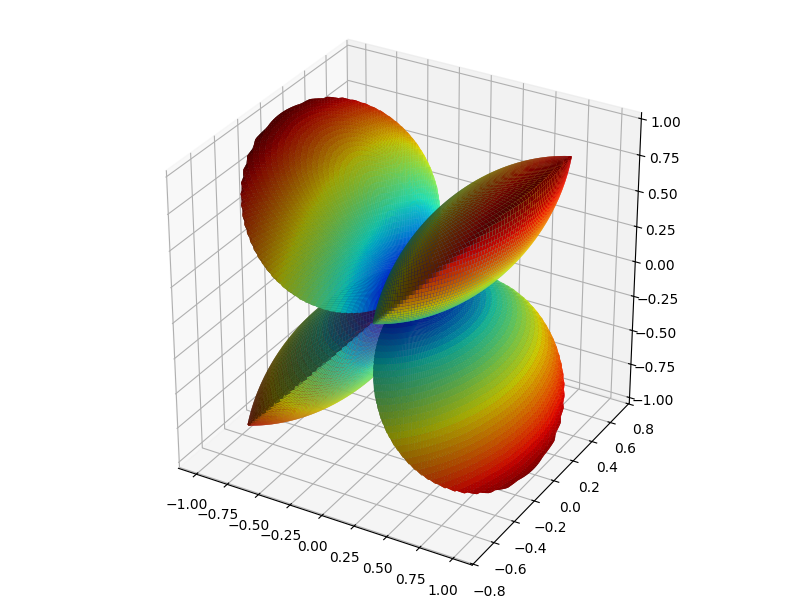

In [126]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_deformed, y_deformed, z_deformed,
                facecolors=plt.cm.jet((radius - radius.min()) / radius.ptp()),
                rstride=1, cstride=1, linewidth=0, antialiased=True)

ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()

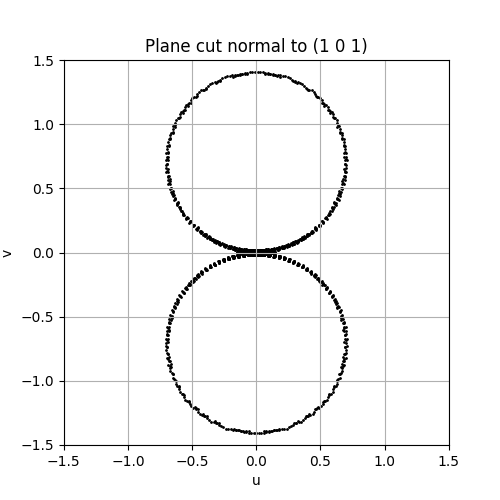

In [140]:
plot_plane_cut(x_deformed,y_deformed,z_deformed,[1,0,1])